## Libraries

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import re
import datetime
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import mediapipe as mp
import time

from face_extraction_v2 import extract_faces
import threading



In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Config

In [4]:
model_name = 'inception_resnet_model'

if model_name == 'vit_model':
    IMG_SIZE = 256
elif model_name == 'inception_model':
    IMG_SIZE = 299
elif model_name == 'inception_resnet_model':
    IMG_SIZE = 299
elif model_name == 'vgg_model':
    IMG_SIZE = 224
else:
    IMG_SIZE = 224

IMAGE_SIZE = (IMG_SIZE,IMG_SIZE)

NUM_FEATURES = 512
EPOCHS = 40
batch_size = 32
random_seed = 2024


learning_rate = 0.0001
weight_decay = 0.0001

## Modeling

In [5]:
# from model_architectures import resnet50_model as ml_model
# from model_architectures import inceptionv3_model as ml_model
from model_architectures import inception_resnet_v2_model as ml_model

### Training Model

In [6]:
def run_experiment(model_name, pretrained = False, Training = False):
    if pretrained:
      checkpoint_path = "model_architectures/checkpoints/"+model_name+'_pretrained_weights.h5'
      history_file_path = 'model_architectures/histories/'+model_name+'_pretrained_history.xlsx'
    else:
      checkpoint_path = "model_architectures/checkpoints/"+model_name+'_weights.h5'
      history_file_path = 'model_architectures/histories/'+model_name+'_history.xlsx'

    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor= 'val_loss',
        mode = 'min',
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )

    # log_dir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1)

    model = ml_model.get_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate = learning_rate,
            #weight_decay= weight_decay
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    print(model.summary())

    if not Training:
      checkpoint_path = "model_architectures/final_models/"+model_name+'_collected_dataset/'+model_name+'_weights.h5'
      history_path = "model_architectures/final_models/"+model_name+'_collected_dataset/'+model_name+'_history.xlsx'


      model.load_weights(checkpoint_path)
      history = pd.read_excel(history_path)
      return model, history

    history = model.fit(train_ds,
                        steps_per_epoch = int(len(train_df))//batch_size,
                        validation_data = val_ds,
                        validation_steps = int(len(test_df))//batch_size,
                        epochs = EPOCHS,
                        callbacks = [
                            checkpoint,
                            early_stopping
                            # tensorboard_callback
                            ],
                        )

    pd.DataFrame(history.history).to_excel(history_file_path)

    model.load_weights(checkpoint_path)

    return model, history


In [7]:
model_name = 'inception_resnet_model'
trained_model, history = run_experiment(model_name = model_name, Training = False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

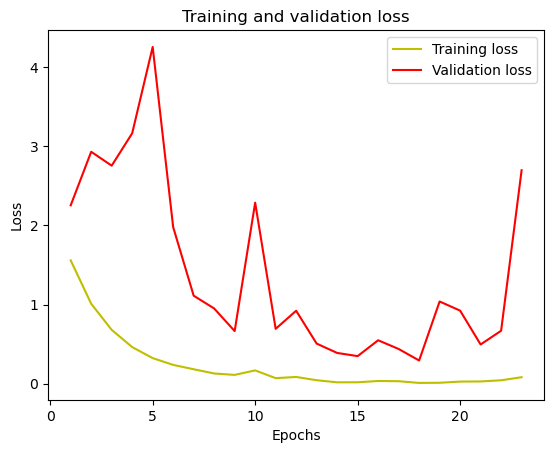

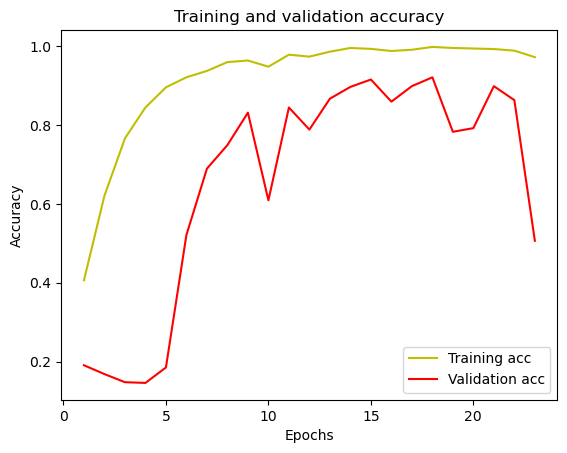

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Inference

In [11]:
## Implement with threading or multiprocessing to make runtime faster
# Define the codec and create VideoWriter object

def inference(video_path, target_fps):

    cap = cv2.VideoCapture(video_path)
    labels = ['angry','fear','happy','neutral','sad','surprised']
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps//target_fps)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # or 'H264'
    out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))
    step_count = 0
    label = ''
    confidence_score = 0
    try:
      while True:
        start = time.time()
        ret, frame = cap.read()
        step_count = step_count+1

        if not ret:
          break

        frame = frame[:, :, [2, 1, 0]]
        # start_time = time.time()
        face, bbox = extract_faces(frame,
                                      target_size = IMAGE_SIZE,
                                      enforce_detection = False,
                                      align = False)
        face = face / 255.
        x, y, w, h = bbox
        if step_count == interval:

            prediction = trained_model.predict(np.expand_dims(face, axis = 0), verbose = 0)
            confidence_score = np.round(np.max(prediction)*100, 2)
            prediction = np.argmax(
               np.round(prediction),
               axis = 1
            )
            label  = labels[prediction[0]]
            step_count = 0

            # duration = time.time() - start_time
            # print(duration)

        roi = frame[y:y+h, x:x+w]

        # Apply blur to the ROI
        blurred_roi = cv2.blur(roi, (30, 30), 0)

        # Paste the blurred ROI back into the original image
        frame[y:y+h, x:x+w] = blurred_roi

        frame = frame[:, :, [2, 1, 0]]
        end = time.time()
        #live_fps = np.ceil(1/(end-start))

        frame = np.ascontiguousarray(frame, dtype=np.uint8)
        cv2.rectangle(frame, (x,y), (x+w, y + h),(0,255,0),3)
        cv2.putText(frame, f'Emotion : {label}', (x,y-20), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255,255,255), 1)
        #cv2.putText(frame, f"FPS: {live_fps}", (x, y-40), cv2.FONT_HERSHEY_DUPLEX, 1, (50, 90, 20),1 )
        cv2.putText(frame, f"Confidence: {confidence_score}", (x, y-40), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255,255,255),1 )
        out.write(frame)
        cv2.imshow("Frame",frame)

        key = cv2.waitKey(1) & 0xFF        

        if key == ord('s'):
           cv2.imwrite(
                'output_image.jpg', frame
             )

        if key == ord('q'):
            break

    finally:
        cap.release()
        cv2.destroyAllWindows()

In [12]:
inference('dataset/participant_2/participant2_sad1.mp4', 10)